# IAU 2023/2024
## **Autori:** Laura Fulajtárová (50%), Bruno Kristián (50%)

# Fáza 3 - Strojové učenie 

In [142]:
import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import plot_tree
from IPython.display import Image
import copy
from collections import Counter
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV




### OneR algoritmus

Dočasne sme spojili dáta z trénovacej a testovacej množiny, aby sme mohli vytvoriť OneR model. 

In [143]:
X_train = pd.read_csv("X_train.csv", sep = ',')
y_train = pd.read_csv("y_train.csv", sep = ',')
X_test = pd.read_csv("X_test.csv", sep = ',')
y_test = pd.read_csv("y_test.csv", sep = ',')

merged_train_data = pd.concat([X_train, y_train], axis=1)
train_data = merged_train_data

merged_test_data = pd.concat([X_test, y_test], axis=1)
test_data = merged_test_data

One Rule algoritmus sme naprogramovali iba pre číselné hodnoty, pretože v dátach sme si v minulých fázach premenili pomocou encodingu všetky kategorické hodnoty na číselné.

In [144]:
def one_rule_algorithm(data, target_variable, explored_columns):
    best_feature = None
    best_accuracy = 0
    
    for feature in data.columns:
        if feature == target_variable or feature in explored_columns:
            continue
        
        mean_values = data.groupby(target_variable)[feature].mean()
        split_point = mean_values.mean()
        
        temp_data = data.copy()
        temp_data['prediction'] = temp_data[feature] > split_point
        
        accuracy = accuracy_score(temp_data[target_variable], temp_data['prediction'])
        precision = precision_score(temp_data[target_variable], temp_data['prediction'])
        recall = recall_score(temp_data[target_variable], temp_data['prediction'])
        
        if accuracy > best_accuracy:
            best_feature = feature
            best_accuracy = accuracy
            best_precision = precision
            best_recall = recall
            result = temp_data['prediction']
    
    return best_feature, best_accuracy, best_precision, best_recall, result

Spustíme algoritmus OneR s predikovanou premennou "ack" a vyhodnotíme metriky.

Na vyhodnotenie modelu sme použili nasledovné metriky:
- Accuracy - ako často klasiﬁkátor správne klasifikoval 

- Precision - koľko správne predikovaných príkladov bolo pozitívnych

- Recall - koľko pozitívnych príkladov bolo správne predikovaných

### OneR s jednou premennou

In [145]:
target_variable = 'ack'

oneR_train_data = copy.deepcopy(train_data)
best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(oneR_train_data, target_variable, [])
print('Best column from OneR:', best_feature)
print('Accuracy:', best_accuracy)
print('Precision:', best_precision)
print('Recall:', best_recall)


Best column from OneR: page_activity_duration
Accuracy: 0.8994723687864482
Precision: 0.8568387440127727
Recall: 0.9453904873752202


Vidíme, že algoritmus vyhodnotil "page_activity_duration" ako najlepšiu premennú pre predikciu "ack". Algoritmus na základe premennej "page_activity_duration" predikoval s presnosťou takmer 90%.

### OneR s viacerými premennými

Teraz skúsime spustiť OneR algoritmus viackrát a zistiť ktoré premenné najlepšie predikujú "ack".

Po zistení najlepších premenných ich použijeme na vytvorenie modelu. Pri vytváraní modelu prihliadame na presnosť predikcie danej premennej. Čím vyššia presnosť, tým má vyššiu váhu pri rozhodaovaní. 

In [146]:
target_variable = 'ack'
results = []
explored_columns = []
final_results = []

for _ in range(5):
    oneR_train_data = copy.deepcopy(train_data)
    best_feature, best_accuracy, best_precision, best_recall, prediction = one_rule_algorithm(oneR_train_data, target_variable, explored_columns)
    explored_columns.append(best_feature)
    results.append((best_accuracy, prediction.tolist()))

for result in results:
    if result[0] > 0.7:
        final_results.append(result[1])
        final_results.append(result[1])
    else:
        final_results.append(result[1])

combined_predictions = [Counter(sample).most_common(1)[0][0] for sample in zip(*final_results)]

overall_accuracy = accuracy_score(train_data[target_variable], combined_predictions)
overall_precision = precision_score(train_data[target_variable], combined_predictions, zero_division=0)
overall_recall = recall_score(train_data[target_variable], combined_predictions)

table_data = {
    "Algorithm": ["OneR"],
    "Accuracy": [overall_accuracy],
    "Precision": [overall_precision],
    "Recall": [overall_recall]
}

oneR_table = pd.DataFrame(table_data)

Najlepšie premenné k predikcií "ack"

In [147]:
table_data = {
    "Feature": explored_columns,
    "Accuracy": [result[0] for result in results]
}

accuracy_table = pd.DataFrame(table_data)
accuracy_table

,Feature,Accuracy
0,page_activity_duration,0.899472
1,pct_input,0.628159
2,pct_doubleclick,0.605110
3,wild_mouse_duration,0.581505
4,pct_click,0.575396


Výsledky metrík pre predikovanie premennej "ack" pomocou OneR algoritmu s viacerými premennými.

In [148]:
print('Overall Accuracy:', overall_accuracy)
print('Overall Precision:', overall_precision)
print('Overall Recall:', overall_recall)

Overall Accuracy: 0.8339350180505415
Overall Precision: 0.8271166370633511
Overall Recall: 0.82031708749266


### Scikit-learn Klasifikátory

Stromový klasifikátor Random Forest.

In [149]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

table_data = {
    "Algorithm": ["Random Forest"],
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall]
}

RF_table = pd.DataFrame(table_data)

feature_importances = clf.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_5_features_rf = sorted_indices[:5]
top_5_importances = feature_importances[top_5_features_rf]

feature_names = X_test.columns.values

top_5_feature_names_rf = [feature_names[i] for i in top_5_features_rf]

c:\Users\Laura\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.95
Precision: 0.93
Recall: 0.97


Stromový klasifikátor Gradient Boosting.

In [150]:
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np

gb_model = GradientBoostingClassifier(n_estimators=100, random_state=1)

gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision = precision_score(y_test, gb_y_pred)
gb_recall = recall_score(y_test, gb_y_pred)

print(f"Accuracy: {gb_accuracy:.2f}")
print(f"Precision: {gb_precision:.2f}")
print(f"Recall: {gb_recall:.2f}")

table_data = {
    "Algorithm": ["Gradient Boosting"],
    "Accuracy": [gb_accuracy],
    "Precision": [gb_precision],
    "Recall": [gb_recall]
}

GB_table = pd.DataFrame(table_data)

feature_importances = gb_model.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_5_features_gb = sorted_indices[:5]
top_5_importances = feature_importances[top_5_features_gb]
feature_names = X_test.columns.values

top_5_feature_names = [feature_names[i] for i in top_5_features_gb]

c:\Users\Laura\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.96
Precision: 0.94
Recall: 0.98


### Nestromový algoritmus

Pre nestromový algoritmus sme si vybrali KNN klasifikátor.

Najskôr si dáta scalujeme a normalizujeme, aby KNN klasifikátor pracoval efektívnejšie.

In [151]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_train)
train_data_scaled = pd.DataFrame(scaled_data, columns=X_train.columns)

power = PowerTransformer(method='yeo-johnson', standardize=True) 
X_train_normalised = power.fit_transform(train_data_scaled)
X_train_scaled_normalised = pd.DataFrame(X_train_normalised, columns=X_train.columns)

scaled_test_data = scaler.transform(X_test)
test_data_scaled = pd.DataFrame(scaled_test_data, columns=X_test.columns)

normalized_test_data = power.transform(test_data_scaled)
test_data_scaled_normalized = pd.DataFrame(normalized_test_data, columns=X_test.columns)

Pri stromových klasifikačných algoritmoch sme nemuseli použiť feature selection, pretože si s tým poradili samé. Pri nestromových algoritmoch je to však inak.

In [152]:
columns_to_keep = [
    'page_activity_duration', 'pct_doubleclick', 'pct_mouse_click', 'wild_mouse_duration',
    'pct_mouse_move', 'pct_input', 'pct_click', 'session_start', 
    'scroll_move_total_rel_distance', 'pct_scroll_move'
]

X_train_filtered = X_train_scaled_normalised[columns_to_keep]
X_test_filtered = test_data_scaled_normalized[columns_to_keep]

KNN klasifikátor

In [153]:
knn_model = KNeighborsClassifier(n_neighbors=10)

knn_model.fit(X_train_filtered, y_train)

knn_y_pred = knn_model.predict(X_test_filtered)

knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print(f"Accuracy: {knn_accuracy:.2f}")
print(f"Precision: {knn_precision:.2f}")
print(f"Recall: {knn_recall:.2f}")

table_data_knn = {
    "Algorithm": ["K-Nearest Neighbors"],
    "Accuracy": [knn_accuracy],
    "Precision": [knn_precision],
    "Recall": [knn_recall]
}

knn_table = pd.DataFrame(table_data_knn)

from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=5)
selector.fit(X_train_filtered, y_train)
top_5_indices = selector.get_support(indices=True)
top_5_features_knn = X_train_filtered.columns[top_5_indices]

Accuracy: 0.97
Precision: 0.96
Recall: 0.97


c:\Users\Laura\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_classification.py:233: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Laura\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Porovnanie výsledkov

In [154]:
display(oneR_table, RF_table, GB_table, knn_table)

,Algorithm,Accuracy,Precision,Recall
0,OneR,0.833935,0.827117,0.820317


,Algorithm,Accuracy,Precision,Recall
0,Random Forest,0.950055,0.929864,0.967059


,Algorithm,Accuracy,Precision,Recall
0,Gradient Boosting,0.962264,0.943311,0.978824


,Algorithm,Accuracy,Precision,Recall
0,K-Nearest Neighbors,0.965594,0.95814,0.969412


Z porovnania výsledkov vidíme, že najlepšie výsledky dosiahol Gradient Boosting klasifikátor.

Náš oneR algoritmus dosiahol presnosť 83%. Dôvodom je jednoduchosť algoritmu a potreba predikovať pomocou viacerých premenných. Keďže najlepší atribút má presnosť okolo 90% a ostané atribúty majú presnosť len okolo 60%, tak pri predikovaní pomocou viacerých atribútov sa presnosť zníži.

OneR algoritmus predikuje s precíznosťou 82%, čo je o viac ako 10% menej ako Gradient Boosting klasifikátor alebo Random Forest klasifikátor.

Náš algoritmus je o 15% horší ako ako Gradient Boosting klasifikátor alebo Random Forest klasifikátor v predikovaní pozitívnych príkladov zo všetkých pozitívnych príkladov.

In [155]:
print("One Rule Algorithm:")
for column in explored_columns:
    print(column)


print("\n")
print("Random Forest:")
for column in top_5_feature_names_rf:
    print(column)


print("\n")
print("Gradient Boosting:")
for column in top_5_feature_names:
    print(column)

print("\n")
print("K Nearest Neighbours:")
for column in top_5_features_knn:
    print(column)

One Rule Algorithm:
page_activity_duration
pct_input
pct_doubleclick
wild_mouse_duration
pct_click


Random Forest:
page_activity_duration
pct_doubleclick
wild_mouse_duration
pct_input
pct_mouse_click


Gradient Boosting:
page_activity_duration
pct_doubleclick
pct_mouse_click
pct_click
pct_mouse_move


K Nearest Neighbours:
page_activity_duration
pct_doubleclick
pct_mouse_move
pct_input
pct_click


Vidíme, že algoritmy sa podobajú vo výbere atribútov, ktoré najlepšie predikujú "ack". Najlepšie atribúty sú "page_activity_duration", "pct_doubleclick" a "pct_click".

#### Vizualizácia natrénovaných pravidiel

Vizualizujeme si Random Forest klasifikátor.

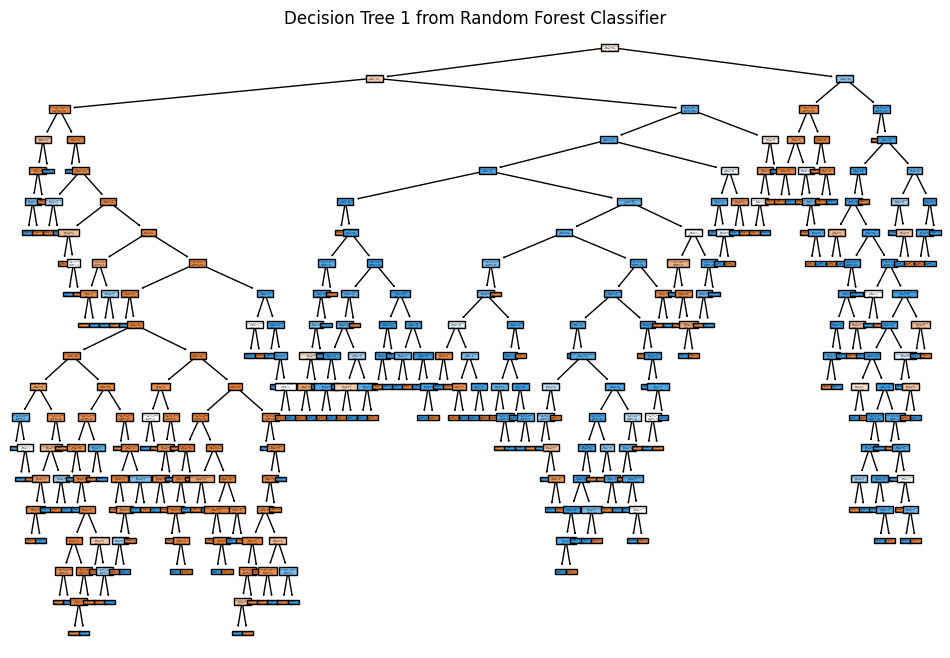

In [156]:
tree_index = 0
plt.figure(figsize=(12, 8))
plot_tree(clf.estimators_[tree_index], filled=True, feature_names=[f"feature_{i}" for i in range(X_test.shape[1])])
plt.title(f"Decision Tree {tree_index + 1} from Random Forest Classifier")
plt.show()

Vizualizácia pravidiel pre Random Forest klasifikátor na základe accuracy.

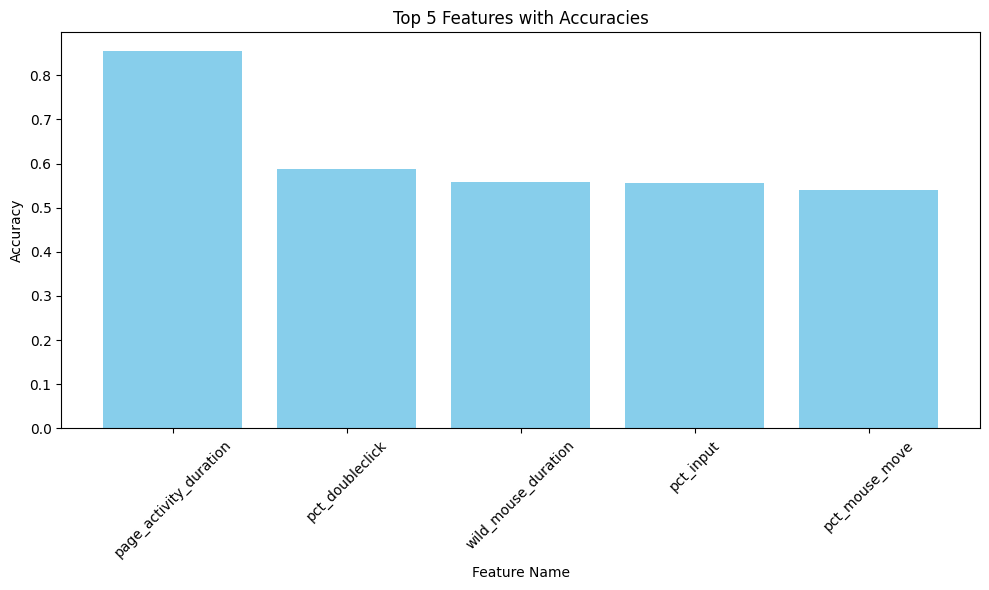

In [157]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

feature_accuracies = []

for i in range(X_train.shape[1]):
    X_train_single_feature = X_train.iloc[:, i:i+1]  # Assuming X_train is a DataFrame
    X_test_single_feature = X_test.iloc[:, i:i+1]    # Assuming X_test is a DataFrame
    
    clf_single_feature = RandomForestClassifier()
    clf_single_feature.fit(X_train_single_feature, y_train.values.ravel())  # Convert y_train to a 1D array
    
    predictions_single_feature = clf_single_feature.predict(X_test_single_feature)
    
    accuracy_single_feature = accuracy_score(y_test, predictions_single_feature)
    feature_accuracies.append((X_train.columns[i], accuracy_single_feature))

sorted_features = sorted(feature_accuracies, key=lambda x: x[1], reverse=True)

top_5_feature_names = [feat[0] for feat in sorted_features[:5]]
top_5_accuracies = [feat[1] for feat in sorted_features[:5]]

plt.figure(figsize=(10, 6))
plt.bar(top_5_feature_names, top_5_accuracies, color='skyblue')
plt.xlabel('Feature Name')
plt.ylabel('Accuracy')
plt.title('Top 5 Features with Accuracies')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [158]:
# vynechanie ostatnych stlpcov
for column in X_train.columns:
    if column not in top_5_feature_names_rf or column not in top_5_feature_names or column not in top_5_features_knn or column not in explored_columns:
        X_train = X_train.drop(column, axis=1)
        X_test = X_test.drop(column, axis=1)

# fixnutie y_train
y_train = y_train.values.ravel()

### Hyperparameter tuning

#### Learning curve pred optimalizáciou

In [159]:
"""from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve


# Initialize and train the GradientBoostingClassifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=1)
gb_model.fit(X_train, y_train)

# Predict and evaluate on the training set
gb_y_train_pred = gb_model.predict(X_train)
gb_train_accuracy = accuracy_score(y_train, gb_y_train_pred)

# Predict and evaluate on the test set
gb_y_test_pred = gb_model.predict(X_test)
gb_test_accuracy = accuracy_score(y_test, gb_y_test_pred)

# Learning curve calculation
train_sizes, train_scores, test_scores = learning_curve(gb_model, X_train, y_train, cv=5, n_jobs=-1, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10))

# Mean and standard deviation for training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Mean and standard deviation for test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue", marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.15)

plt.plot(train_sizes, test_mean, label="Test score", color="green", marker='o')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="green", alpha=0.15)

plt.title("Learning Curve")
plt.xlabel("Training Data Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="lower right")
plt.grid()
plt.show()

gb_train_accuracy, gb_test_accuracy

"""

'from sklearn.metrics import accuracy_score\nfrom sklearn.model_selection import learning_curve\n\n\n# Initialize and train the GradientBoostingClassifier\ngb_model = GradientBoostingClassifier(n_estimators=100, random_state=1)\ngb_model.fit(X_train, y_train)\n\n# Predict and evaluate on the training set\ngb_y_train_pred = gb_model.predict(X_train)\ngb_train_accuracy = accuracy_score(y_train, gb_y_train_pred)\n\n# Predict and evaluate on the test set\ngb_y_test_pred = gb_model.predict(X_test)\ngb_test_accuracy = accuracy_score(y_test, gb_y_test_pred)\n\n# Learning curve calculation\ntrain_sizes, train_scores, test_scores = learning_curve(gb_model, X_train, y_train, cv=5, n_jobs=-1, \n                                                        train_sizes=np.linspace(0.1, 1.0, 10))\n\n# Mean and standard deviation for training set scores\ntrain_mean = np.mean(train_scores, axis=1)\ntrain_std = np.std(train_scores, axis=1)\n\n# Mean and standard deviation for test set scores\ntest_mean = np.

Výsledky ukazujú, že model dosiahol presnosť 95.67% na trénovacej množine a 94.56% na testovacej množine. Tieto hodnoty sú veľmi blízke k sebe, čo naznačuje, že model má dobrú schopnosť generalizácie a nie je výrazne preučený (overfitovaný). Tento výsledok je pozitívny, pretože ukazuje, že model dobre predpovedá na dátach, na ktorých nebol trénovaný.

#### Complexity curve pred optimalizáciou

In [160]:
"""from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Analysis for varying model complexity
results = []
max_depth_range = range(1, 11)  # Varying max_depth from 1 to 10

for depth in max_depth_range:
    gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=depth, random_state=1)
    gb_model.fit(X_train, y_train)
    
    # Calculate error on training set
    train_pred = gb_model.predict(X_train)
    train_error = 1 - accuracy_score(y_train, train_pred)

    # Calculate error on test set
    test_pred = gb_model.predict(X_test)
    test_error = 1 - accuracy_score(y_test, test_pred)

    results.append({'max_depth': depth, 'train_error': train_error, 'test_error': test_error})

# Convert results to a DataFrame for easier plotting
import pandas as pd
results_df = pd.DataFrame(results)

# Plotting the errors vs model complexity
plt.figure(figsize=(10, 6))
plt.plot(results_df['max_depth'], results_df['train_error'], label='Training Error', marker='o', color='blue')
plt.plot(results_df['max_depth'], results_df['test_error'], label='Testing Error', marker='o', color='red')

plt.title("Error vs. Model Complexity (Max Depth)")
plt.xlabel("Max Depth")
plt.ylabel("Error (1 - Accuracy)")
plt.legend()
plt.grid()
plt.show()

results_df

"""

'from sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.metrics import accuracy_score\nimport matplotlib.pyplot as plt\n\n# Analysis for varying model complexity\nresults = []\nmax_depth_range = range(1, 11)  # Varying max_depth from 1 to 10\n\nfor depth in max_depth_range:\n    gb_model = GradientBoostingClassifier(n_estimators=100, max_depth=depth, random_state=1)\n    gb_model.fit(X_train, y_train)\n    \n    # Calculate error on training set\n    train_pred = gb_model.predict(X_train)\n    train_error = 1 - accuracy_score(y_train, train_pred)\n\n    # Calculate error on test set\n    test_pred = gb_model.predict(X_test)\n    test_error = 1 - accuracy_score(y_test, test_pred)\n\n    results.append({\'max_depth\': depth, \'train_error\': train_error, \'test_error\': test_error})\n\n# Convert results to a DataFrame for easier plotting\nimport pandas as pd\nresults_df = pd.DataFrame(results)\n\n# Plotting the errors vs model complexity\nplt.figure(figsize=(10, 6))\nplt.p

S rastúcou hĺbkou stromu (max_depth) v Gradient Boosting modeli dochádza k poklesu chyby na trénovacej množine, avšak chyba na testovacej množine sa stabilizuje pri max_depth 7. Ďalšie zvyšovanie hĺbky stromu neprináša zlepšenie na testovacej množine, čo naznačuje optimálnu hĺbku okolo 7 a potenciálne riziko overfittingu pri vyšších hodnotách.

#### Gradient Boosting classifier

Gradient Boosting je veľmi presný model, obzvlášť účinný pri práci s komplexnými dátami, čo je výhodné v rôznych aplikáciách od klasifikácie po regresiu. Jeho flexibilita umožňuje prispôsobenie rozličným typom stratových funkcií, čo ho robí vhodným pre rôzne prediktívne úlohy. Okrem toho, ponúka viacero možností na kontrolu overfittingu, ako napríklad nastavenie hĺbky stromu a rýchlosti učenia, čo zlepšuje jeho schopnosť generalizovať na nevidené dáta.

##### Vysvetlenie hyperparametrov

In [161]:
params = GradientBoostingClassifier().get_params()
for key, value in params.items():
    print(f"{key}: {value}")

ccp_alpha: 0.0
criterion: friedman_mse
init: None
learning_rate: 0.1
loss: log_loss
max_depth: 3
max_features: None
max_leaf_nodes: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_iter_no_change: None
random_state: None
subsample: 1.0
tol: 0.0001
validation_fraction: 0.1
verbose: 0
warm_start: False


- ccp_alpha: Komplexita stromu. Čím vyššia hodnota, tým viac sa strom zjednoduší.
- criterion: Kritérium pre výber atribútu, ktorý sa použije na rozdelenie uzla.
- init: Inicializácia stromu.
- learning_rate: Rýchlosť učenia.
- loss: Funkcia straty.
- max_depth: Maximálna hĺbka stromu.
- max_features: Maximálny počet atribútov, ktoré sa použijú na rozdelenie uzla.
- max_leaf_nodes: Maximálny počet listových uzlov.
- min_impurity_decrease: Uzol sa rozdelí, ak sa impurity v jeho rodičovskom uzle zníži o túto hodnotu.
- min_samples_leaf: Minimálny počet vzoriek v listovom uzle.
- min_weight_fraction_leaf: Minimálna váhová frakcia v listovom uzle.
- n_estimators: Počet stromov v ensemble.
- n_iter_no_change: Počet iterácií bez zlepšenia pred ukončením učenia.
- random_state: Seed pre generovanie náhodných čísel.
- subsample: Podiel vzoriek použitých na trénovanie každého stromu.
- tol: Tolerancia pre zastavenie učenia.
- validation_fraction: Podiel vzoriek použitých na validáciu každého stromu.
- verbose: Výpis informácií o učení.
- warm_start: Použiť existujúci model na trénovanie a pridať ďalšie stromy do ensemble.

In [177]:
estimator = GradientBoostingClassifier()

# Define your parameter grid
gb_parameters = {
    'criterion': ['friedman_mse', 'squared_error'],
    'loss': ['log_loss','exponential'],
    'max_depth': [3,6,8],
    'n_estimators': [100,200, 300],
    'learning_rate': [0.09, 0.1,0.11],
    'random_state': [None,1],
    'min_samples_split': [2,3,4],
    'min_samples_leaf': [1,2,3],
    
    }

scoring = ['accuracy', 'precision_micro']

# Initialize GridSearchCV
gb_clf = GridSearchCV(estimator=estimator, 
                   param_grid=gb_parameters,
                   cv=5,
                   scoring=scoring,
                   refit='accuracy', 
                   n_jobs=-1)

# Fit the grid search
gb_search = gb_clf.fit(X_train, y_train)

# Output the results
print(gb_search.best_estimator_)
print(gb_search.best_score_)
print(gb_search.best_params_)
print(gb_search.n_splits_)

GradientBoostingClassifier(learning_rate=0.09, max_depth=6, min_samples_split=4,
                           random_state=1)
0.9369617814763446
{'criterion': 'friedman_mse', 'learning_rate': 0.09, 'loss': 'log_loss', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 1}
5


##### Gradient Boosting before hyperparameter tuning

In [178]:
gb_model = GradientBoostingClassifier()

gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision2 = precision_score(y_test, gb_y_pred)
gb_recall2 = recall_score(y_test, gb_y_pred)

print(f"Accuracy: {gb_accuracy:.5f}")
print(f"Precision: {gb_precision2:.5f}")
print(f"Recall: {gb_recall2:.5f}")

Accuracy: 0.94340
Precision: 0.91928
Recall: 0.96471


##### Gradient Boosting after hyperparameter tuning

In [181]:
gb_model = gb_search.best_estimator_

gb_model.fit(X_train, y_train)

gb_y_pred = gb_model.predict(X_test)

gb_accuracy = accuracy_score(y_test, gb_y_pred)
gb_precision2 = precision_score(y_test, gb_y_pred)
gb_recall2 = recall_score(y_test, gb_y_pred)

print(f"Accuracy: {gb_accuracy:.5f}")
print(f"Precision: {gb_precision2:.5f}")
print(f"Recall: {gb_recall2:.5f}")

Accuracy: 0.93896
Precision: 0.92237
Recall: 0.95059


#### Random Forest classifier

Random Forest je obľúbený pre svoju robustnosť a výkonnosť, ktorá je často porovnateľná s komplexnejšími modelmi. Vďaka svojmu spôsobu náhodnej výberu prvkov a tvorby stromov poskytuje Random Forest vynikajúcu odolnosť voči overfittingu. Táto metóda je tiež schopná efektívne spracovávať veľké dátove sady s veľkým počtom premenných, čo je výhodné pri riešení širokej škály úloh prediktívnej analýzy.

##### Vysvetlenie hyperparametrov

In [165]:
params = RandomForestClassifier().get_params()
for key, value in params.items():
    print(f"{key}: {value}")

bootstrap: True
ccp_alpha: 0.0
class_weight: None
criterion: gini
max_depth: None
max_features: sqrt
max_leaf_nodes: None
max_samples: None
min_impurity_decrease: 0.0
min_samples_leaf: 1
min_samples_split: 2
min_weight_fraction_leaf: 0.0
n_estimators: 100
n_jobs: None
oob_score: False
random_state: None
verbose: 0
warm_start: False


- bootstrap: Použiť bootstrap vzorkovanie. Bootstrap vzorkovanie je metóda, ktorá sa používa na zlepšenie presnosti modelu.
- class_weight: Váhy tried.
- max_samples: Maximálny počet vzoriek použitých na trénovanie každého stromu.
-  n_jobs: Počet jadier procesora použitých na trénovanie.
-  oob_score: Použiť out-of-bag vzorky na odhad presnosti. Out-of-bag vzorky sú vzorky, ktoré neboli použité na trénovanie stromu.

In [166]:
estimator = RandomForestClassifier()

# Random Forest Parameters
rf_parameters = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 6],
    'min_samples_leaf': [1, 4],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

scoring = ['accuracy', 'precision_micro']

rf_clf = GridSearchCV(
    estimator=estimator, 
    param_grid=rf_parameters, 
    scoring=scoring,
    refit='accuracy', 
    cv=5, 
    n_jobs=-1
)

rf_search = rf_clf.fit(X_train, y_train)

print(rf_search.best_estimator_)
print(rf_search.best_score_)
print(rf_search.best_params_)
print(rf_search.n_splits_)


RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=4)
0.9408498998304825
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
5


##### Random Forest before hyperparameter tuning

In [167]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")

Accuracy: 0.94784
Precision: 0.93548
Recall: 0.95529


##### Random Forest after hyperparameter tuning

In [168]:
clf = rf_search.best_estimator_
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)

print(f"Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall: {recall:.5f}")

Accuracy: 0.94784
Precision: 0.92955
Recall: 0.96235


#### KNeighbors classifier

K-Nearest Neighbors (KNN) je známy svojou jednoduchosťou a intuitívnosťou, čo uľahčuje jeho pochopenie a implementáciu. Jeho flexibilita výberu počtu susedov a metrík vzdialenosti umožňuje prispôsobiť model špecifickým potrebám dát. Navyše, KNN je efektívny pri zachytávaní komplexných vzorov v dátach, čo je výhodné, keď sú presné predpovede založené na podobnosti dát kľúčové.

##### Vysvetlenie hyperparametrov


In [169]:
params = KNeighborsClassifier().get_params()
for key, value in params.items():
    print(f"{key}: {value}")

algorithm: auto
leaf_size: 30
metric: minkowski
metric_params: None
n_jobs: None
n_neighbors: 5
p: 2
weights: uniform


- algorithm: Algoritmus použitý na nájdenie najbližších susedov. Algoritmus môže byť "ball_tree", "kd_tree", "brute" alebo "auto".
- leaf_size: Veľkosť listového uzla.
- metric: Metrika použitá na výpočet vzdialenosti medzi bodmi. Metrika môže byť "euclidean", "manhattan" alebo "minkowski".
- n_neighbors: Počet najbližších susedov.
- p: Parameter pre metriku "minkowski".
- weights: Váhy použité na predikciu bodu. Váhy môžu byť "uniform" alebo "distance".

In [170]:
estimator = KNeighborsClassifier()

# KNN Parameters
knn_parameters = {
    'n_neighbors': [ 5, 10, 15, 20,25,30],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [20, 30, 40, 50],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'n_jobs': [-1, None],
    'p': [1, 2]
    
}

scoring = ['accuracy', 'precision_micro']

knn_clf = GridSearchCV(
    estimator=estimator, 
    param_grid=knn_parameters, 
    scoring=scoring,
    refit='accuracy', 
    cv=5, 
    n_jobs=-1
)

knn_search = knn_clf.fit(X_train, y_train)

print(knn_search.best_estimator_)
print(knn_search.best_score_)
print(knn_search.best_params_)
print(knn_search.n_splits_)

KNeighborsClassifier(leaf_size=20, metric='manhattan', n_jobs=-1,
                     n_neighbors=30, p=1)
0.9358514408999847
{'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_jobs': -1, 'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}
5


In [171]:
knn_model = KNeighborsClassifier()

knn_model.fit(X_train_filtered, y_train)

knn_y_pred = knn_model.predict(X_test_filtered)

knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print(f"Accuracy: {knn_accuracy:.5f}")
print(f"Precision: {knn_precision:.5f}")
print(f"Recall: {knn_recall:.5f}")

Accuracy: 0.95450
Precision: 0.95070
Recall: 0.95294


In [172]:
knn_model = knn_search.best_estimator_

knn_model.fit(X_train_filtered, y_train)

knn_y_pred = knn_model.predict(X_test_filtered)

knn_accuracy = accuracy_score(y_test, knn_y_pred)
knn_precision = precision_score(y_test, knn_y_pred)
knn_recall = recall_score(y_test, knn_y_pred)

print(f"Accuracy: {knn_accuracy:.5f}")
print(f"Precision: {knn_precision:.5f}")
print(f"Recall: {knn_recall:.5f}")

Accuracy: 0.96337
Precision: 0.95370
Recall: 0.96941


#### Voting ensemble 

In [182]:
from sklearn.ensemble import VotingClassifier

# Create individual models with their best parameters
model1 = gb_search.best_estimator_
model2 = rf_search.best_estimator_
model3 = knn_search.best_estimator_

# Create a voting classifier
voting_clf = VotingClassifier(
    estimators=[('gb', model1), ('rf', model2), ('knn', model3)],
    voting='hard'
)

# Fit the voting classifier
voting_clf.fit(X_train, y_train)

# Evaluate the model
voting_score = voting_clf.score(X_test, y_test)
print(f"Voting Classifier Score: {voting_score}")


Voting Classifier Score: 0.946725860155383


#### Stacking ensemble

In [183]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Create individual models with their best parameters
model1 = gb_search.best_estimator_
model2 = rf_search.best_estimator_
model3 = knn_search.best_estimator_

# Define the stacking ensemble
stacking_clf = StackingClassifier(
    estimators=[('gb', model1), ('rf', model2), ('knn', model3)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Fit the stacking classifier
stacking_clf.fit(X_train, y_train)

# Evaluate the model
stacking_score = stacking_clf.score(X_test, y_test)
print(f"Stacking Classifier Score: {stacking_score}")


Stacking Classifier Score: 0.9422863485016648


Použitá literatúra:
- https://github.com/thismlguy/analytics_vidhya/tree/master/Articles/Parameter_Tuning_GBM_with_Example
- https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
